# Advanced Programming Assessment - Part 2
### Puffin dataset analysis - Classifier

## Data cleaning and exploration


In [1]:
import pandas as pd

# Reading in puffins data to dataframe and visualising first few rows (dataset must be in same folder)
puffins = pd.read_csv('puffins.csv')
puffins.head()

,body_mass_kg,wing_length_m,beak_length_mm,beak_depth_mm,species
0,4.0,0.2,39.3,19.4,Arctica
1,3.1,0.2,38.6,18.3,Arctica
2,3.7,0.2,40.8,16.7,Arctica
3,4.5,0.2,41.5,17.9,Arctica
4,3.3,0.2,42.3,17.1,Arctica


In [2]:
# Removing rows where NA values are present
puffins = puffins.dropna()

# Checking how many samples we have (with rows containing missing values already removed)
puffins.count()

body_mass_kg      340
wing_length_m     340
beak_length_mm    340
beak_depth_mm     340
species           340
dtype: int64

In [3]:
# Listing species
puffins['species'].unique()

array(['Arctica', 'Cirrhata', 'Corniculata'], dtype=object)

### The features and target 

Features (X) : body_mass_kg, wing_length_m, beak_length_mm, beak_depth_mm   
To predict (y) : species (Arctica, Cirrhata and Corniculata)

In [4]:
# visual check looks like wing_length_m is the same in each sample, verifying this with `value_counts`:
puffins['wing_length_m'].value_counts()

0.2    340
Name: wing_length_m, dtype: int64

As the `wing_length_m` feature has the same recorded value for each sample, it will NOT be included in the model as it has no *predictive value.*

In [5]:
# count of each species
puffins.groupby('species').size()

species
Arctica        151
Cirrhata        68
Corniculata    121
dtype: int64

In [6]:
# summary of all the numerical data
puffins.describe()

,body_mass_kg,wing_length_m,beak_length_mm,beak_depth_mm
count,340.000000,3.400000e+02,340.000000,340.000000
mean,4.324706,2.000000e-01,45.225882,16.647941
std,0.827714,1.250842e-15,5.635515,1.911237
min,2.800000,2.000000e-01,33.100000,12.700000
25%,3.700000,2.000000e-01,40.400000,15.100000
50%,4.150000,2.000000e-01,45.550000,16.800000
75%,4.900000,2.000000e-01,50.000000,18.100000
max,6.500000,2.000000e-01,61.400000,20.900000


In [7]:
# Encoding the categorical target variable species as numerical values (species 0, 1 and 2)
# (most algorithms need numerical data)
from sklearn.preprocessing import LabelEncoder

# Creating the encoded target variable and adding to the dataframe
puffins['species_target'] = LabelEncoder().fit_transform(puffins['species'])

In [8]:
# Excluding 'wing_length_m' from features, setting X (features) and y (target)
X = puffins[['body_mass_kg', 'beak_length_mm', 'beak_depth_mm']]
y = puffins['species_target']

## Correlation Analysis
Visualising how the data are related to each other.

In [9]:
# getting the linear correlation between the 3 selected features
corr = X.corr()
corr

,body_mass_kg,beak_length_mm,beak_depth_mm
body_mass_kg,1.000000,0.595209,-0.470838
beak_length_mm,0.595209,1.000000,-0.235700
beak_depth_mm,-0.470838,-0.235700,1.000000


In [10]:
# finding out the most negative correlation between two features:
corr.min().idxmin(), corr[corr.min().idxmin()].idxmin()

('body_mass_kg', 'beak_depth_mm')

In [11]:
# with the value:
corr.min().min()

-0.4708379150571954

In [12]:
# numpy required for data manipualtion to find the most positive correlation
import numpy as np

corr_max = X.corr()

# removing the 1.0 values on diagonal to help find most positive correlation
np.fill_diagonal(corr_max.values, np.nan)
corr_max

,body_mass_kg,beak_length_mm,beak_depth_mm
body_mass_kg,NaN,0.595209,-0.470838
beak_length_mm,0.595209,NaN,-0.235700
beak_depth_mm,-0.470838,-0.235700,NaN


In [13]:
# finding out the most positive correlation between two features:
corr_max.max().idxmax(), corr_max[corr_max.max().idxmax()].idxmax()

('body_mass_kg', 'beak_length_mm')

In [14]:
# with the value:
corr_max.max().max()

0.5952089544192327

From these results, it can be inferred that `body_mass_kg` is may predict both `beak_length_mm` and `beak_depth_mm`.


### Visual overview of correlation coefficients

<AxesSubplot:>

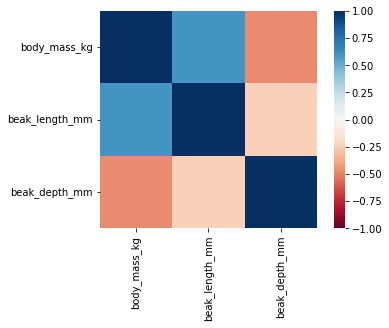

In [15]:
%matplotlib inline

import seaborn as sns

# visualising correlation coefficients as a heat map
sns.heatmap(corr, vmin=-1.0, vmax=1.0, square=True, cmap="RdBu")

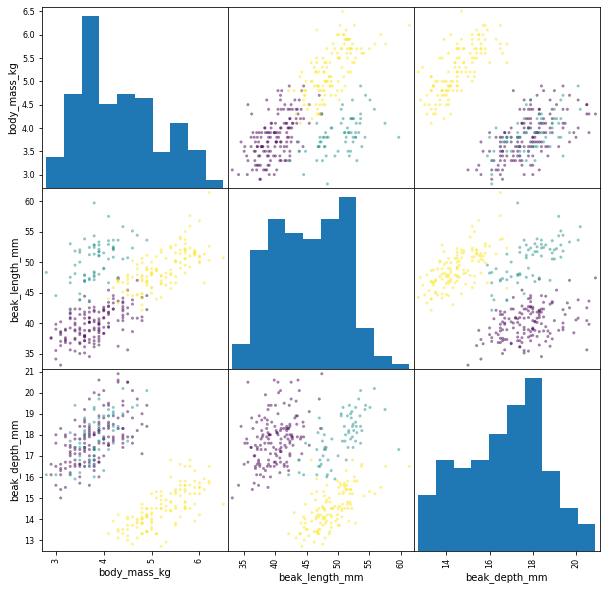

In [16]:
from pandas.plotting import scatter_matrix

# multi-variable scatter matrix to see how all features (except wing_length) correlate
a = scatter_matrix(X, figsize=(10, 10), c=y)

Each colour in the above plot represents a different puffin species. Distinct grouping can be seen in plots between `beak_length_mm` and `beak_depth_mm`. As well as `body_mass_kg` and `beak_length_mm`.

# Classifier using the kNN algorithm

Correlation analysis showed relatively distinct groups between features `beak_length_mm` and `beak_depth_mm` so these will be selected first, to give a rough idea of model performance and allow for simpler visualisation.

In [17]:
# creating subset of beak_length and beak_depth (correlation analysis shows distinct grouping between species)
X_subset = X[["beak_depth_mm", "beak_length_mm"]]

In [18]:
from sklearn.model_selection import train_test_split

# splitting data into subset of data to fit with and subset to test against
train_X_s, test_X_s, train_y_s, test_y_s = train_test_split(X_subset, y, random_state=42)

In [19]:
from sklearn.neighbors import KNeighborsClassifier

# running kNN with default parameters
knn = KNeighborsClassifier()

# Fitting and scoring the model
knn.fit(train_X_s, train_y_s)
knn.score(test_X_s, test_y_s)

0.9764705882352941

In [20]:
# the plot_knn function
def plot_knn(model, X, y, resolution=100, ax=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    if X.shape[1] != 2:
        raise ValueError(f"X must have exactly two features to plot, you passed X.shape={X.shape}")
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    x1 = X.iloc[:,0]
    x2 = X.iloc[:,1]
    x1_range = np.linspace(x1.min()*1.1 - x1.max()*0.1, x1.max()*1.1 - x1.min()*0.1, resolution)
    x2_range = np.linspace(x2.min()*1.1 - x2.max()*0.1, x2.max()*1.1 - x2.min()*0.1, resolution)
    grid_x1_values, grid_x2_values = np.meshgrid(x1_range, x2_range)
    x_prime = np.column_stack((grid_x1_values.ravel(), grid_x2_values.ravel()))
    x_prime = pd.DataFrame(x_prime, columns=X.columns)
    y_hat = model.predict(x_prime).reshape(grid_x1_values.shape)

    if ax is None:
        fig, ax = plt.subplots()
    ax.pcolormesh(grid_x1_values, grid_x2_values, y_hat, cmap="Pastel2", alpha=1.0, shading="auto")
    X.plot.scatter(0, 1, c=y, colormap="Dark2", colorbar=False, alpha=0.8, ax=ax)

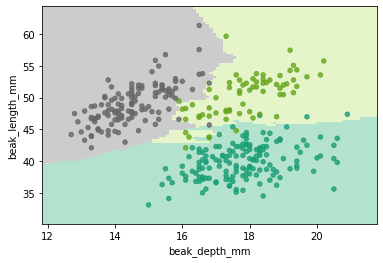

In [21]:
# importing function to look at the distribution of predictions compared to the input data
# from plot import plot_knn

# plotting data
plot_knn(knn, X_subset, y)

## Building the pipeline

With all features considered.

In [22]:
# Splitting data into train and test subsets using all 3 features
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)

In [23]:
# Using GridSearchCV to find best "n_neighbors" hyperparameter for the model
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# parameters to test, and range from 1-51 neighbors
parameters = {
    "n_neighbors" : range(1, 51),
}
model = GridSearchCV(KNeighborsClassifier(), parameters)
model.fit(train_X, train_y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 51)})

<AxesSubplot:xlabel='param_n_neighbors', ylabel='mean_test_score'>

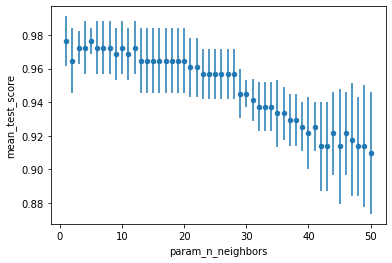

In [24]:
# Visualising results from GridSearchCV
cv_results = pd.DataFrame(model.cv_results_)
cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score")

Here, can see that `n_neighbors = 5` is the best as it has the highest mean test score and smallest std deviation.

### Principal component analysis
To select the most important features.

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# using GridSearchCV to see which number of principal components is best
pca_knn_cv = GridSearchCV(
    make_pipeline(
        PCA(),
        KNeighborsClassifier(n_neighbors=5)
    ),
    {
        "pca__n_components" : range(1, 4), # ranging from 1-4 (there are only 3 features)
    }
)
pca_knn_cv

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'pca__n_components': range(1, 4)})

In [26]:
# fitting and scoring the model
pca_knn_cv.fit(train_X, train_y)
pca_knn_cv.score(test_X, test_y)

0.9882352941176471

In [27]:
# prints the 'best' estimated no. of components to include
pca_knn_cv.best_estimator_["pca"].n_components_

3

As the features are on slightly different scales, adding a feature-scaling step may improve the model.

### The Final Pipeline

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# making the pipeline with 3 steps
knn_model = make_pipeline(
        StandardScaler(), # addition of the feature_scaling step
        PCA(n_components=3),
        KNeighborsClassifier(n_neighbors=5)
    )

# fitting and scoring the model
knn_model.fit(train_X, train_y)
knn_model.score(test_X, test_y)

1.0

In [29]:
sum(knn_model["pca"].explained_variance_ratio_)

1.0

Improved model: `score = 1.0`. And explains all the variance in the data.

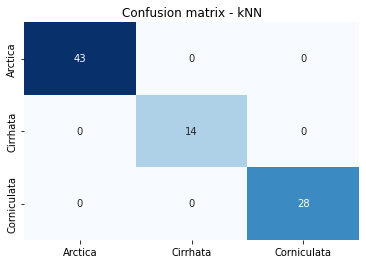

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generating a confusion matrix for visualisation of the performance of the model
test_pred = knn_model.predict(test_X)
cm = confusion_matrix(test_y, test_pred)

# Defining the labels
species_lab = ["Arctica", "Cirrhata", "Corniculata"]

# Plot the confusion matrix using seaborn
ax = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
ax.set_xticklabels(species_lab)
ax.set_yticklabels(species_lab)
ax.set_title('Confusion matrix - kNN')

# Show the plot
plt.show()

### N.B: Performance of the subsetted model

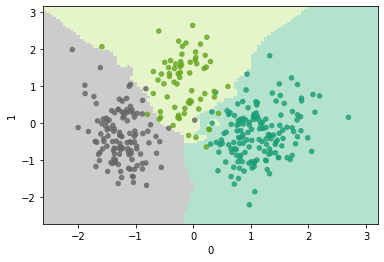

In [31]:
# only 'beak_length_mm' and 'beak_depth_mm'
knn_model_s = make_pipeline(
        StandardScaler(), # addition of the feature_scaling step
        PCA(n_components=2),
        KNeighborsClassifier(n_neighbors=5)
    )

knn_model_s.fit(train_X_s, train_y_s)

# Pulling out tranformation steps from final kNN step
transformer_steps = knn_model_s[:-1]  
knn_step = knn_model_s[-1]  

# passing transformed data into plotting function
transformed_X = transformer_steps.transform(X_subset)

# plotting decision boundaries of data
plot_knn(knn_step, transformed_X, y)

In [32]:
knn_model_s.score(test_X_s, test_y_s)

0.9882352941176471

In [33]:
sum(knn_model_s["pca"].explained_variance_ratio_)

1.0

Subsetted model explains all variance yet model score suggests it is less well-performing than the model with all features.

### Alternative algorithm: Gaussian Naive Bayes Classifier

In [34]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes model with default parameters
nb_model = GaussianNB()

# Fitting the model to the training data
nb_model.fit(train_X, train_y)

# Predict the labels for the test data
nb_pred = nb_model.predict(test_X)

# Evaluating the performance of the model
from sklearn.metrics import accuracy_score

# Printing accuracy (comparable to model score) and precision
accuracy_score(test_y, nb_pred)

0.9647058823529412

Suggests knn is likely a better algorithm for fitting the data.

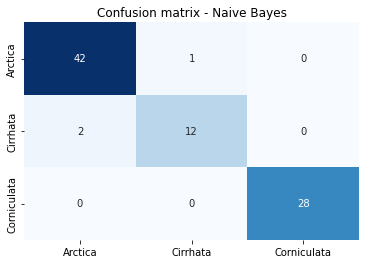

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generating a confusion matrix for visualisation of the performance of the model
test_pred_nb = nb_model.predict(test_X)
cm_nb = confusion_matrix(test_y, test_pred_nb)

# Defining the labels
species_lab = ["Arctica", "Cirrhata", "Corniculata"]

# Plot the confusion matrix using seaborn
ax = sns.heatmap(cm_nb, annot=True, cmap="Blues", fmt="d", cbar=False)
ax.set_xticklabels(species_lab)
ax.set_yticklabels(species_lab)
ax.set_title('Confusion matrix - Naive Bayes')

# Show the plot
plt.show()

# Assessing the effectiveness of the data analysis pipeline 
## (292 words)

Prior to data analysis, rows with missing data were removed from the raw dataset so that the model is trained on complete data, increasing accuracy. For feature selection, `wing_length_m` was excluded as it had no predictive value due to identical recorded values seen in each sample. Relationships between features were visually represented using correlation analysis, providing insight into which features may predict species the best. The K-nearest neighbours (kNN) algorithm was selected as it is a non-parametric algorithm and so can handle non-linear relationships between multiple features. Correlation analysis revealed distinct grouping between species so it was expected that decision boundaries between species should be relatively clear, allowing the kNN algorithm to perform well. Hyperparameters were decided using `GridSearchCV` to find the best value for `n_neighbours`, requiring little manual input. One weakness of the kNN algorithm is the curse of dimensionality, where increasing the number of features deteriorates model performance, to counter this a principal component analysis (PCA) step was used in the pipeline. `GridSearchCV` was further used to see which `n_components` value for PCA led to a better fitting model. A feature-scaling step was also added to the pipeline. This is because kNN relies on distance-based calculations so even small differences in scale between features will negatively impact performance. Model evaluation revealed a perfect score; however, this was only tested on a small subset of test data, therefore further evaluation on more unseen data may be needed to further validate the model, as perfect scores can suggest overfitting. An alternative algorithm, the gaussian naïve bayes was also trialled, however, under default parameters, this scored worse than the kNN algorithm with the confusion matrix showing a couple of misclassifications, although tuning of hyperparameters may bring this in line with the kNN model.